In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, homogeneity_completeness_v_measure, silhouette_score, calinski_harabasz_score, davies_bouldin_score


In [6]:
from google.colab import drive
drive.mount('/content/drive')
import os
import pandas as pd

os.chdir('/content/drive/MyDrive/ml_projekt/Project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls '/content/drive/My Drive/Colab Notebooks/Magister/Machine learning/Project/'

ls: cannot access '/content/drive/My Drive/Colab Notebooks/Magister/Machine learning/Project/': No such file or directory


# Describing and exploring data

## Plant generation data:
Period of collecting data: 34 days, 15 minutes interval, idependently for each inverter (detemined by `SOURCE_KEY`)

`DATE_TIME` - Date and time for each observation, 3158 unique values

*   format for `PLANT_1`: 15-05-2020 00:00
*   format for `PLANT_2`: 2020-05-15 00:00:00


`PLANT_ID` - common for the entire file

`SOURCE_KEY` - inverter ID

`DC_POWER` - amount of DC power generated by the inverter (source_key) in this 15 minute interval, units: kW
<font color="lightgreen"> Tabelis raporteeritud väärtus on 15 minuti keskmine tootlus, ehk võimsus (tinglikult: $\frac{kW\cdot h}{h}$). Kui tahame raporteeritud DC_POWER'ite järgi arvutada DAILY_YIELD või TOTAL_YIELD tuleb DC_POWER jagada 4-ga (ehk siis $\frac{60min}{15min}$). </font>

`AC_POWER` - amount of AC power generated by the inverter (source_key) in this 15 minutes interval, units: kW

`DAILY_YIELD` - cumulative sum of power generated on that day, till that point in the time.

`TOTAL_YIELD` - total yield for the inverter till that point in time.

## Weather data:
Weather sensor data gathered for one solar each solar plant every 15 minutes over a 34 days period.

`DATE_TIME` - date and time for each observation, recorded at 15 min intervals
*   format for `WEATHER_1`: 2020-05-15 00:00:00
*   format for `WEATHER_2`: 2020-05-15 00:00:00

`PLANT_ID` - common for the entire file

`SOURCE_KEY` - stands for the sensor panel ID, will be common for the entire file

`AMBIENT_TEMPERATURE` - ambient temperature at the plant

`MODULE_TEMPERATURE` - There's a module (solar panel) attached to the sensor panel. This is the temperature reading for that module.

`IRRADIATION` - amount of the irradiation for the 15 min interval. <font color="red">Unit unknown! Irradiance is usually measured in $\frac{W}{m^2}$ but since it is given for 15 minutes interval it might also be total energy presented in units $\frac{J}{m^2}$. Further research must be made considering that maximum and average irradiance are correspondedly $max=1.22 \quad mean=0.23$. </font>


In [5]:
drive.mount('/content/drive')
dir='/content/drive/My Drive/Colab Notebooks/Magister/Machine learning/Project/'
plant_1_GD = pd.read_csv(dir+'Plant_1_Generation_Data.csv')
plant_2_GD = pd.read_csv(dir+'Plant_2_Generation_Data.csv')
plant_1_WD = pd.read_csv(dir+'Plant_1_Weather_Sensor_Data.csv')
plant_2_WD = pd.read_csv(dir+'Plant_2_Weather_Sensor_Data.csv')

# Changing the format of the Date Time in all data
plant_1_GD['DATE_TIME'] = pd.to_datetime(plant_1_GD['DATE_TIME'])
plant_2_GD['DATE_TIME'] = pd.to_datetime(plant_2_GD['DATE_TIME'])
plant_1_WD['DATE_TIME'] = pd.to_datetime(plant_1_WD['DATE_TIME'])
plant_2_WD['DATE_TIME'] = pd.to_datetime(plant_2_WD['DATE_TIME'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/Colab Notebooks/Magister/Machine learning/Project/Plant_1_Generation_Data.csv'

In [7]:
#martin
plant_1_GD = pd.read_csv('Plant_1_Generation_Data.csv')
plant_2_GD = pd.read_csv('Plant_2_Generation_Data.csv')
plant_1_WD = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')
plant_2_WD = pd.read_csv('Plant_2_Weather_Sensor_Data.csv')

# Changing the format of the Date Time in all data
plant_1_GD['DATE_TIME'] = pd.to_datetime(plant_1_GD['DATE_TIME'])
plant_2_GD['DATE_TIME'] = pd.to_datetime(plant_2_GD['DATE_TIME'])
plant_1_WD['DATE_TIME'] = pd.to_datetime(plant_1_WD['DATE_TIME'])
plant_2_WD['DATE_TIME'] = pd.to_datetime(plant_2_WD['DATE_TIME'])

<ipython-input-7-b7e2fa2de6d3>:8: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  plant_1_GD['DATE_TIME'] = pd.to_datetime(plant_1_GD['DATE_TIME'])


In [8]:

plant_1_GD['DC_POWER'] = plant_1_GD['DC_POWER']/10

In [9]:
# Combining weather and generation data
combined_1 = plant_1_GD.merge(plant_1_WD, on = 'DATE_TIME', how = 'outer' )
combined_2 = plant_2_GD.merge(plant_2_WD, on = 'DATE_TIME', how = 'outer' )

In [12]:
combined_1['DC/IRR'] = combined_1['DC_POWER']/combined_1['IRRADIATION']
combined_2['DC/IRR'] = combined_2['DC_POWER']/combined_2['IRRADIATION']
combined_1['DC/AC'] = combined_1['DC_POWER']/combined_1['AC_POWER']
combined_2['DC/AC'] = combined_2['DC_POWER']/combined_2['AC_POWER']


In [13]:
row_has_nan = combined_1.isna().any(axis=1)
print(row_has_nan)

0        True
1        True
2        True
3        True
4        True
         ... 
68798    True
68799    True
68800    True
68801    True
68802    True
Length: 68803, dtype: bool


In [14]:
X_train, X_test = train_test_split(combined_1, test_size=0.2, random_state=42)
print(f"train shape: {X_train.shape}")
print(f"test shape: {X_test.shape}")

train shape: (55042, 14)
test shape: (13761, 14)


In [15]:
print('pikkus', len(plant_1_GD['DATE_TIME'].unique()))
print(plant_1_GD.shape)
print(plant_1_GD.shape[0]/len(plant_1_GD['DATE_TIME'].unique()))

pikkus 3158
(68778, 7)
21.77897403419886


## Plotting weather data

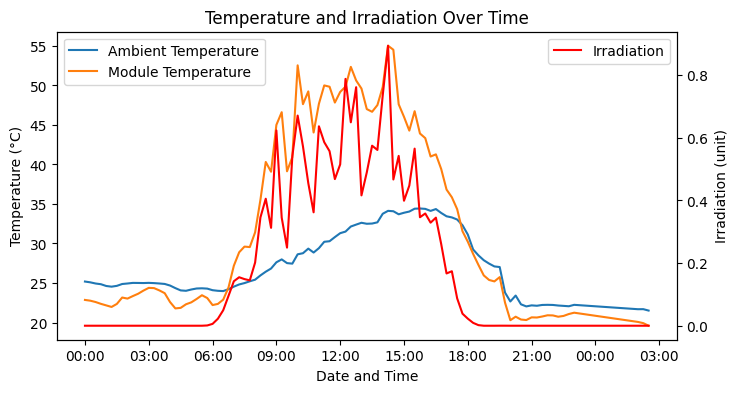

In [16]:
import matplotlib.dates as mdates

n = 96

fig, ax1 = plt.subplots(figsize = (8,4))  # Create the main plot and axes

# Plot ambient and module temperature on the primary y-axis
ax1.plot(plant_1_WD['DATE_TIME'][:n], plant_1_WD['AMBIENT_TEMPERATURE'][:n], label='Ambient Temperature')
ax1.plot(plant_1_WD['DATE_TIME'][:n], plant_1_WD['MODULE_TEMPERATURE'][:n], label='Module Temperature')
ax1.set_xlabel('Date and Time')  # Set x-axis label
ax1.set_ylabel('Temperature (°C)')  # Set y-axis label for temperature
ax1.legend(loc="upper left")  # Add legend for temperature plots

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot irradiation on the secondary y-axis
ax2.plot(plant_1_WD['DATE_TIME'][:n], plant_1_WD['IRRADIATION'][:n], color='red', label='Irradiation')
ax2.set_ylabel('Irradiation (unit)')  # Set y-axis label for irradiation
ax2.legend(loc="upper right")  # Add legend for irradiation plot

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format as HH:MM

plt.title('Temperature and Irradiation Over Time')  # Set plot title
plt.show()  # Display the plot

## Plotting generation data

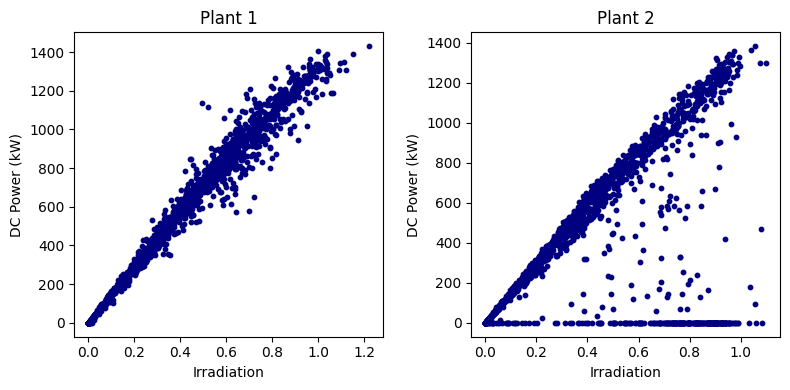

In [17]:
# prompt: plot me the first inverter from each plant. I want irradiation on x axis and generated DC on y axis. Put them next to each other and use only points (no lines in between the points). Don't make it a function. Just two graphs on subplots next to each other.

import matplotlib.pyplot as plt

# Assuming combined_1 and combined_2 DataFrames are already defined as in the provided code

# Select the first inverter from each plant
plant1_first_inverter = combined_1[combined_1['SOURCE_KEY_x'] == combined_1['SOURCE_KEY_x'].unique()[1]]
plant2_first_inverter = combined_2[combined_2['SOURCE_KEY_x'] == combined_2['SOURCE_KEY_x'].unique()[1]]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot Plant 1 data
ax1.scatter(plant1_first_inverter['IRRADIATION'], plant1_first_inverter['DC_POWER'], color = "navy", s = 10)
ax1.set_xlabel('Irradiation')
ax1.set_ylabel('DC Power (kW)')
ax1.set_title('Plant 1')

# Plot Plant 2 data
ax2.scatter(plant2_first_inverter['IRRADIATION'], plant2_first_inverter['DC_POWER'], color = "navy", s = 10)
ax2.set_xlabel('Irradiation')
ax2.set_ylabel('DC Power (kW)')
ax2.set_title('Plant 2')

plt.tight_layout()
plt.show()

## Clustering - final approach:

<font color = 'lightgreen'> Let's split the data to train and test. First 80% of the points will be considered as a training data.

In [27]:
scaler = StandardScaler()

#uuritav_1 = combined_1.copy()
#uuritav_2 = combined_2.copy()

uuritav_1 = pd.merge(
    plant_1_GD[['DATE_TIME', 'DC_POWER', 'SOURCE_KEY']],   # Select only DATE_TIME and DC_POWER
    plant_1_WD[['DATE_TIME', 'IRRADIATION']],  # Select only DATE_TIME and IRRADIATION
    on='DATE_TIME',  # Common column to merge on
    how='inner'  # Use inner join to keep only matching DATE_TIME values
)

uuritav_2 = pd.merge(
    plant_2_GD[['DATE_TIME', 'DC_POWER', 'SOURCE_KEY']],   # Select only DATE_TIME and DC_POWER
    plant_2_WD[['DATE_TIME', 'IRRADIATION']],  # Select only DATE_TIME and IRRADIATION
    on='DATE_TIME',  # Common column to merge on
    how='inner'  # Use inner join to keep only matching DATE_TIME values
)

#It only makes sense to kluster point that have Irradiation > 0,
#because the period of time when panels do not produce are out of our interest.
uuritav_1 = uuritav_1[uuritav_1['IRRADIATION'] > 0]
uuritav_2 = uuritav_2[uuritav_2['IRRADIATION'] > 0]

train_size = 0.8
uuritav_1_dates = uuritav_1['DATE_TIME'].unique()
uuritav_2_dates = uuritav_2['DATE_TIME'].unique()

train_dates_1 = uuritav_1_dates[:int(len(uuritav_1_dates)*train_size)]
test_dates_1 = uuritav_1_dates[int(len(uuritav_1_dates)*train_size):]
train_dates_2 = uuritav_2_dates[:int(len(uuritav_2_dates)*train_size)]
test_dates_2 = uuritav_2_dates[int(len(uuritav_2_dates)*train_size):]

# Divide uuritav_1 into train and test sets based on dates
train_1 = uuritav_1[uuritav_1['DATE_TIME'].isin(train_dates_1)].copy()
test_1 = uuritav_1[uuritav_1['DATE_TIME'].isin(test_dates_1)].copy()

# Divide uuritav_2 into train and test sets based on dates
train_2 = uuritav_2[uuritav_2['DATE_TIME'].isin(train_dates_2)].copy()
test_2 = uuritav_2[uuritav_2['DATE_TIME'].isin(test_dates_2)].copy()


#train_1, test_1 = train_test_split(uuritav_1, test_size=0.4, random_state=411)
#train_2, test_2 = train_test_split(uuritav_2, test_size=0.4, random_state=411)

#scaler_1 = StandardScaler()
#scaler_2 = StandardScaler()

#Should we scale our data??
#train_1[['DC_POWER', 'IRRADIATION']] = scaler_1.fit_transform(train_1[['DC_POWER', 'IRRADIATION']])
#train_2[['DC_POWER', 'IRRADIATION']] = scaler_2.fit_transform(train_2[['DC_POWER', 'IRRADIATION']])

#test_1[['DC_POWER', 'IRRADIATION']] = scaler_1.transform(test_1[['DC_POWER', 'IRRADIATION']])
#test_2[['DC_POWER', 'IRRADIATION']] = scaler_2.transform(test_2[['DC_POWER', 'IRRADIATION']])

train_1['DC/IRR'] = train_1['DC_POWER']/train_1['IRRADIATION']
train_2['DC/IRR'] = train_2['DC_POWER']/train_2['IRRADIATION']
test_1['DC/IRR'] = test_1['DC_POWER']/test_1['IRRADIATION']
test_2['DC/IRR'] = test_2['DC_POWER']/test_2['IRRADIATION']


train = pd.concat([train_1, train_2])
test = pd.concat([test_1, test_2])

print(f"train_1 shape: {train_1.shape}")
print(f"test_1  shape: {test_1.shape}")
print(f"train_2 shape: {train_2.shape}")
print(f"test_2  shape: {test_2.shape}")
print(f"train   shape: {train.shape}")
print(f"test    shape: {test.shape}")

train_1 shape: (30654, 5)
test_1  shape: (7722, 5)
train_2 shape: (30516, 5)
test_2  shape: (8206, 5)
train   shape: (61170, 5)
test    shape: (15928, 5)


<font color = 'lightgreen'>  Let's fit two k-means clustering algorithms:


In [28]:
n_clusters = 2

kmeans_1 = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_2 = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_3 = KMeans(n_clusters=n_clusters, random_state=42)

# Initialize the GMM model
gmm_3 = GaussianMixture(n_components=n_clusters, random_state=42)

# Fit the model to your data

kmeans_1.fit(train_1['DC/IRR'].values.reshape(-1, 1))
kmeans_2.fit(train_2['DC/IRR'].values.reshape(-1, 1))

train['KM_clusters'] = kmeans_3.fit_predict(train['DC/IRR'].values.reshape(-1, 1))
train['GMM_clusters'] = gmm_3.fit_predict(train['DC/IRR'].values.reshape(-1, 1))

train_2['KM_clusters'] = kmeans_2.predict(train_2['DC/IRR'].values.reshape(-1, 1))
train_1['KM_clusters'] = kmeans_1.predict(train_1['DC/IRR'].values.reshape(-1, 1))
train_2	['GMM_clusters'] = gmm_3.predict(train_2['DC/IRR'].values.reshape(-1, 1))
train_1['GMM_clusters'] = gmm_3.predict(train_1['DC/IRR'].values.reshape(-1, 1))

Let's vizualise the clusters

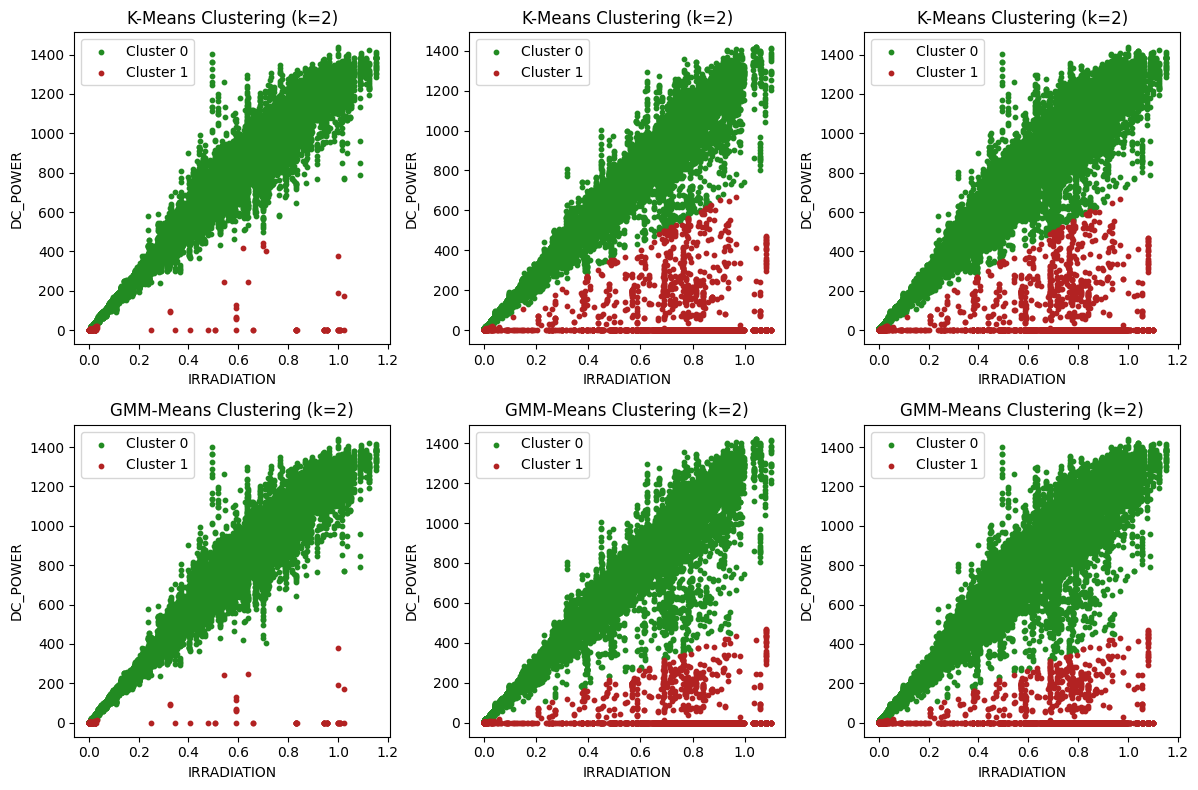

In [29]:
# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

ax1, ax2, ax3, ax4, ax5, ax6 = axs.flatten()

ax1.scatter(y = train_1[train_1['KM_clusters'] == 0]['DC_POWER'], x = train_1[train_1['KM_clusters'] == 0]['IRRADIATION'], label='Cluster 0', color = "forestgreen", s = 10)
ax1.scatter(y = train_1[train_1['KM_clusters'] == 1]['DC_POWER'], x = train_1[train_1['KM_clusters'] == 1]['IRRADIATION'], label='Cluster 1', color = "firebrick", s = 10)
ax1.set_title(f'K-Means Clustering (k={n_clusters})')
ax1.set_ylabel('DC_POWER')
ax1.set_xlabel('IRRADIATION')  # Corrected y-axis label
ax1.legend()  # Add a legend to distinguish clusters

ax4.scatter(y = train_1[train_1['GMM_clusters'] == 0]['DC_POWER'], x = train_1[train_1['GMM_clusters'] == 0]['IRRADIATION'], label='Cluster 0', color = "forestgreen", s = 10)
ax4.scatter(y = train_1[train_1['GMM_clusters'] == 1]['DC_POWER'], x = train_1[train_1['GMM_clusters'] == 1]['IRRADIATION'], label='Cluster 1', color = "firebrick", s = 10)
ax4.set_title(f'GMM-Means Clustering (k={n_clusters})')
ax4.set_ylabel('DC_POWER')
ax4.set_xlabel('IRRADIATION')  # Corrected y-axis label
ax4.legend()  # Add a legend to distinguish clusters


ax2.scatter(y = train_2[train_2['KM_clusters'] == 0]['DC_POWER'], x = train_2[train_2['KM_clusters'] == 0]['IRRADIATION'], label='Cluster 0', color = "forestgreen", s = 10)
ax2.scatter(y = train_2[train_2['KM_clusters'] == 1]['DC_POWER'], x = train_2[train_2['KM_clusters'] == 1]['IRRADIATION'], label='Cluster 1', color = "firebrick", s = 10)
ax2.set_title(f'K-Means Clustering (k={n_clusters})')
ax2.set_ylabel('DC_POWER')
ax2.set_xlabel('IRRADIATION')
ax2.legend()

ax5.scatter(y = train_2[train_2['GMM_clusters'] == 0]['DC_POWER'], x = train_2[train_2['GMM_clusters'] == 0]['IRRADIATION'], label='Cluster 0', color = "forestgreen", s = 10)
ax5.scatter(y = train_2[train_2['GMM_clusters'] == 1]['DC_POWER'], x = train_2[train_2['GMM_clusters'] == 1]['IRRADIATION'], label='Cluster 1', color = "firebrick", s = 10)
ax5.set_title(f'GMM-Means Clustering (k={n_clusters})')
ax5.set_ylabel('DC_POWER')
ax5.set_xlabel('IRRADIATION')  # Corrected y-axis label
ax5.legend()  # Add a legend to distinguish clusters

ax3.scatter(y = train[train['KM_clusters'] == 0]['DC_POWER'], x = train[train['KM_clusters'] == 0]['IRRADIATION'], label='Cluster 0', color = "forestgreen", s = 10)
ax3.scatter(y = train[train['KM_clusters'] == 1]['DC_POWER'], x = train[train['KM_clusters'] == 1]['IRRADIATION'], label='Cluster 1', color = "firebrick", s = 10)
ax3.set_title(f'K-Means Clustering (k={n_clusters})')
ax3.set_ylabel('DC_POWER')
ax3.set_xlabel('IRRADIATION')
ax3.legend()

ax6.scatter(y = train[train['GMM_clusters'] == 0]['DC_POWER'], x = train[train['GMM_clusters'] == 0]['IRRADIATION'], label='Cluster 0', color = "forestgreen", s = 10)
ax6.scatter(y = train[train['GMM_clusters'] == 1]['DC_POWER'], x = train[train['GMM_clusters'] == 1]['IRRADIATION'], label='Cluster 1', color = "firebrick", s = 10)
ax6.set_title(f'GMM-Means Clustering (k={n_clusters})')
ax6.set_ylabel('DC_POWER')
ax6.set_xlabel('IRRADIATION')  # Corrected y-axis label
ax6.legend()  # Add a legend to distinguish clusters

plt.tight_layout()
plt.show()

<font color = 'lightgreen'>  Let's try to evaluate the clusters. First, lets use other, more suitable clustering algorithm to get labels for test data.

In [30]:
from sklearn.cluster import AgglomerativeClustering

# Initialize Agglomerative Clustering
agglomerative_clustering = AgglomerativeClustering(n_clusters=2,
                                                   metric = "euclidean",
                                                   linkage = "ward")

# Fit and predict labels for test_1
test_1['Agg_labels'] = agglomerative_clustering.fit_predict((test_1['DC/IRR'].values.reshape(-1, 1)))

# Fit and predict labels for test_2
test_2['Agg_labels'] = agglomerative_clustering.fit_predict(test_2['DC/IRR'].values.reshape(-1, 1))

test['Agg_labels'] = agglomerative_clustering.fit_predict(test['DC/IRR'].values.reshape(-1, 1))

<font color = lightgreen> Lets visualize the result. </font>

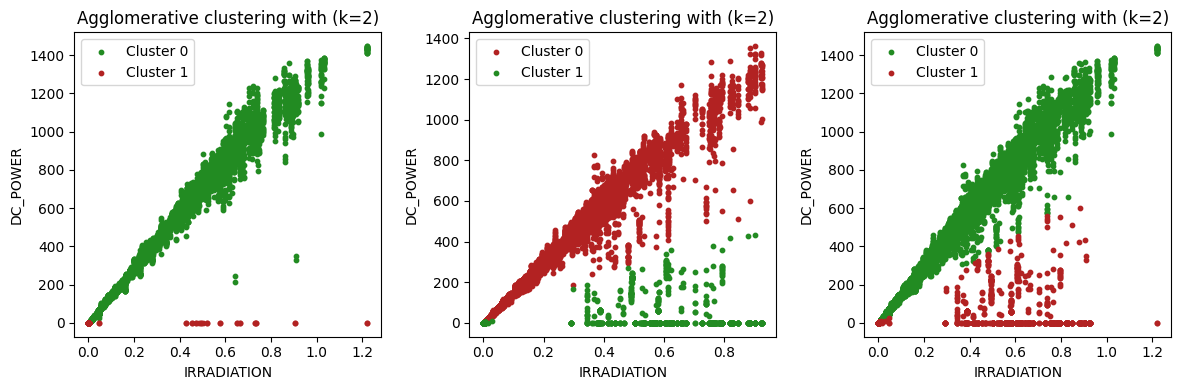

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.scatter(y = test_1[test_1['Agg_labels'] == 0]['DC_POWER'], x = test_1[test_1['Agg_labels'] == 0]['IRRADIATION'], label='Cluster 0', color = "forestgreen", s = 10)
ax1.scatter(y = test_1[test_1['Agg_labels'] == 1]['DC_POWER'], x = test_1[test_1['Agg_labels'] == 1]['IRRADIATION'], label='Cluster 1', color = "firebrick", s = 10)
ax1.set_title(f'Agglomerative clustering with (k={n_clusters})')
ax1.set_ylabel('DC_POWER')
ax1.set_xlabel('IRRADIATION')  # Corrected y-axis label
ax1.legend()  # Add a legend to distinguish clusters

ax2.scatter(y = test_2[test_2['Agg_labels'] == 0]['DC_POWER'], x = test_2[test_2['Agg_labels'] == 0]['IRRADIATION'], label='Cluster 0', color = "firebrick", s = 10)
ax2.scatter(y = test_2[test_2['Agg_labels'] == 1]['DC_POWER'], x = test_2[test_2['Agg_labels'] == 1]['IRRADIATION'], label='Cluster 1', color = "forestgreen", s = 10)
ax2.set_title(f'Agglomerative clustering with (k={n_clusters})')
ax2.set_ylabel('DC_POWER')
ax2.set_xlabel('IRRADIATION')
ax2.legend()

ax3.scatter(y = test[test['Agg_labels'] == 0]['DC_POWER'], x = test[test['Agg_labels'] == 0]['IRRADIATION'], label='Cluster 0', color = "forestgreen", s = 10)
ax3.scatter(y = test[test['Agg_labels'] == 1]['DC_POWER'], x = test[test['Agg_labels'] == 1]['IRRADIATION'], label='Cluster 1', color = "firebrick", s = 10)
ax3.set_title(f'Agglomerative clustering with (k={n_clusters})')
ax3.set_ylabel('DC_POWER')
ax3.set_xlabel('IRRADIATION')
ax3.legend()

plt.tight_layout()
plt.show()

<font color = 'lightgreen'> Let's try predicting the test data, with the prefitted model.

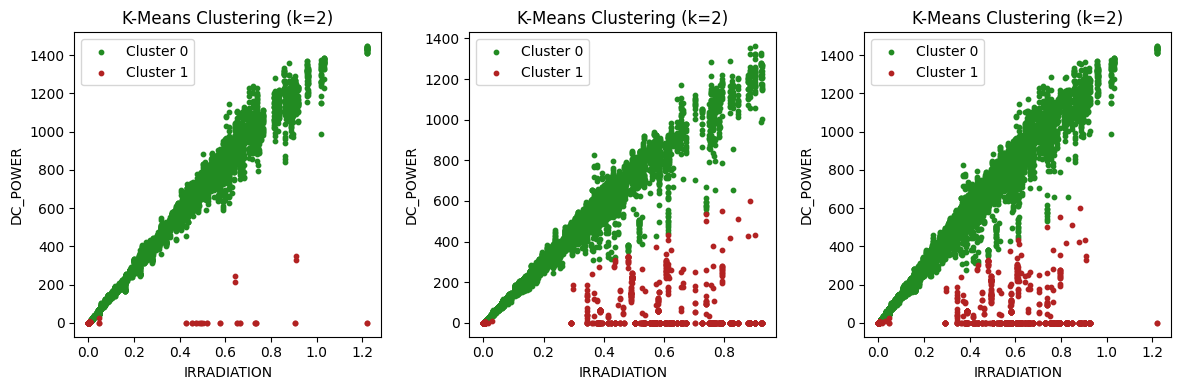

In [33]:
test_1['KM_clusters'] = kmeans_1.predict(test_1['DC/IRR'].values.reshape(-1, 1))
test_2['KM_clusters'] = kmeans_2.predict(test_2['DC/IRR'].values.reshape(-1, 1))
test['KM_clusters'] = kmeans_3.predict(test['DC/IRR'].values.reshape(-1, 1))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.scatter(y = test_1[test_1['KM_clusters'] == 0]['DC_POWER'], x = test_1[test_1['KM_clusters'] == 0]['IRRADIATION'], label='Cluster 0', color = "forestgreen", s = 10)
ax1.scatter(y = test_1[test_1['KM_clusters'] == 1]['DC_POWER'], x = test_1[test_1['KM_clusters'] == 1]['IRRADIATION'], label='Cluster 1', color = "firebrick", s = 10)
ax1.set_title(f'K-Means Clustering (k={n_clusters})')
ax1.set_ylabel('DC_POWER')
ax1.set_xlabel('IRRADIATION')  # Corrected y-axis label
ax1.legend()  # Add a legend to distinguish clusters

ax2.scatter(y = test_2[test_2['KM_clusters'] == 0]['DC_POWER'], x = test_2[test_2['KM_clusters'] == 0]['IRRADIATION'], label='Cluster 0', color = "forestgreen", s = 10)
ax2.scatter(y = test_2[test_2['KM_clusters'] == 1]['DC_POWER'], x = test_2[test_2['KM_clusters'] == 1]['IRRADIATION'], label='Cluster 1', color = "firebrick", s = 10)
ax2.set_title(f'K-Means Clustering (k={n_clusters})')
ax2.set_ylabel('DC_POWER')
ax2.set_xlabel('IRRADIATION')
ax2.legend()

ax3.scatter(y = test[test['KM_clusters'] == 0]['DC_POWER'], x = test[test['KM_clusters'] == 0]['IRRADIATION'], label='Cluster 0', color = "forestgreen", s = 10)
ax3.scatter(y = test[test['KM_clusters'] == 1]['DC_POWER'], x = test[test['KM_clusters'] == 1]['IRRADIATION'], label='Cluster 1', color = "firebrick", s = 10)
ax3.set_title(f'K-Means Clustering (k={n_clusters})')
ax3.set_ylabel('DC_POWER')
ax3.set_xlabel('IRRADIATION')
ax3.legend()

plt.tight_layout()
plt.show()

<font color = lightgreen> Lets calculate the accuracy and Silhouette score!! </font>

In [34]:
# prompt: find me the accuracies for clustering test_1, test_2 and test. Use the Agg_labels as true label.

from sklearn.metrics import accuracy_score

# Calculate accuracy for test_1
accuracy_test_1 = accuracy_score(test_1['Agg_labels'], test_1['KM_clusters'])
accuracy_test_2 = 1 - accuracy_score(test_2['Agg_labels'], test_2['KM_clusters'])
accuracy_test = 1 - accuracy_score(test['Agg_labels'], test['KM_clusters'])


# Silhouette Score (requires distance matrix, use 'euclidean' for example)
silhouette_avg_test = silhouette_score(test[['DC/IRR']], test['KM_clusters'], metric='euclidean')
silhouette_avg_test_1 = silhouette_score(test_1[['DC/IRR']], test_1['KM_clusters'], metric='euclidean')
silhouette_avg_test_2 = silhouette_score(test_2[['DC/IRR']], test_2['KM_clusters'], metric='euclidean')

silhouette_avg_train = silhouette_score(train[['DC/IRR']], train['KM_clusters'], metric='euclidean')
silhouette_avg_train_1 = silhouette_score(train_1[['DC/IRR']], train_1['KM_clusters'], metric='euclidean')
silhouette_avg_train_2 = silhouette_score(train_2[['DC/IRR']], train_2['KM_clusters'], metric='euclidean')

print(f"Accuracy for test_1: {round(accuracy_test_1, 3)}")
print(f"Accuracy for test_2: {round(accuracy_test_2, 3)}")
print(f"Accuracy for test:   {round(accuracy_test, 3)}")
print()
print(f"Silhouette Score for train:   {round(silhouette_avg_train, 3)}")
print(f"Silhouette Score for test:    {round(silhouette_avg_test, 3)}")
print()
print(f"Silhouette Score for train_1: {round(silhouette_avg_train_1, 3)}")
print(f"Silhouette Score for test_1:  {round(silhouette_avg_test_1, 3)}")
print()
print(f"Silhouette Score for train_2: {round(silhouette_avg_train_2, 3)}")
print(f"Silhouette Score for test_2:  {round(silhouette_avg_test_2, 3)}")



Accuracy for test_1: 0.994
Accuracy for test_2: 0.005
Accuracy for test:   0.001

Silhouette Score for train:   0.877
Silhouette Score for test:    0.885

Silhouette Score for train_1: 0.881
Silhouette Score for test_1:  0.906

Silhouette Score for train_2: 0.876
Silhouette Score for test_2:  0.875


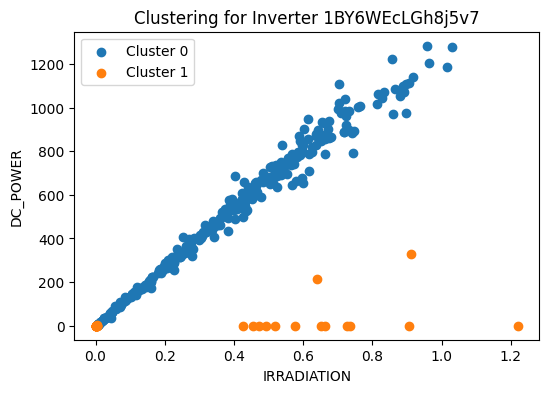

Silhouette Score for Inverter 1BY6WEcLGh8j5v7: 0.9098294899719186


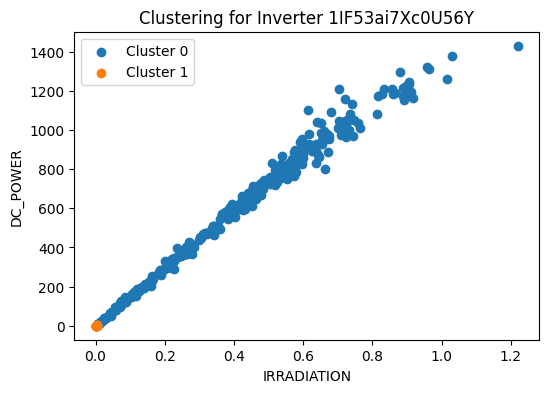

Silhouette Score for Inverter 1IF53ai7Xc0U56Y: 0.9179316138619851


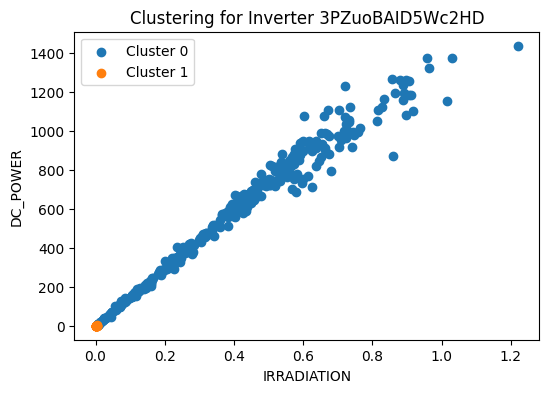

Silhouette Score for Inverter 3PZuoBAID5Wc2HD: 0.9039473796825364


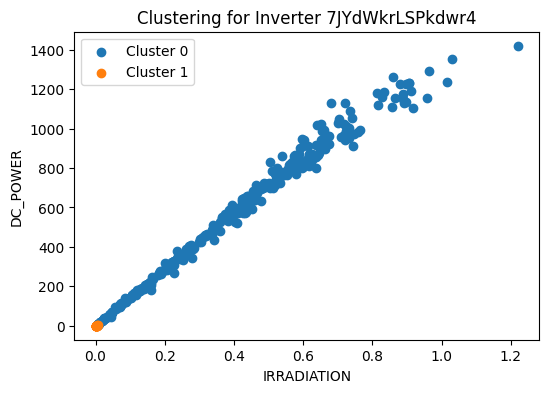

Silhouette Score for Inverter 7JYdWkrLSPkdwr4: 0.9222483558126071


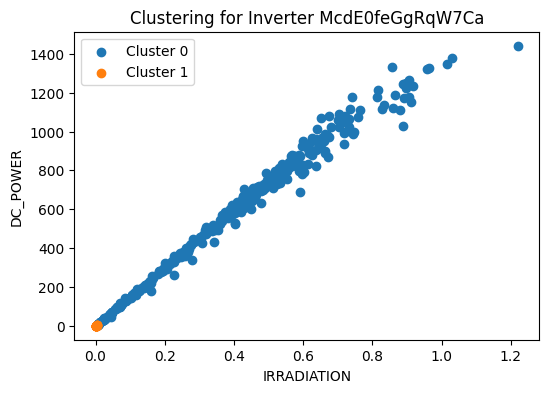

Silhouette Score for Inverter McdE0feGgRqW7Ca: 0.9102457965462905


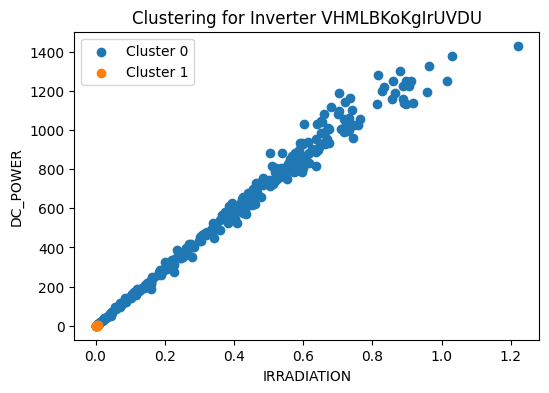

Silhouette Score for Inverter VHMLBKoKgIrUVDU: 0.9156484828865675


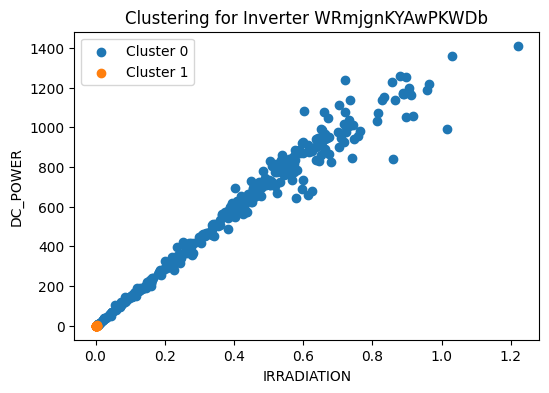

Silhouette Score for Inverter WRmjgnKYAwPKWDb: 0.8967197325053741


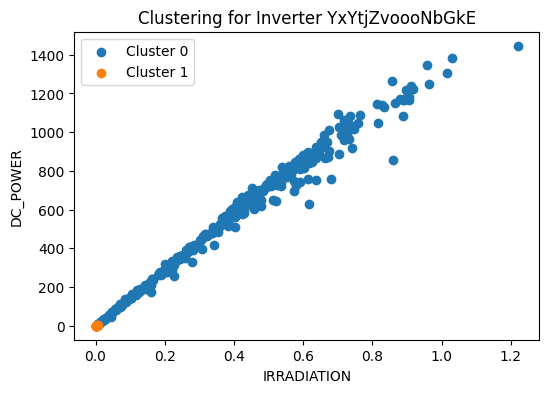

Silhouette Score for Inverter YxYtjZvoooNbGkE: 0.9120923841096021


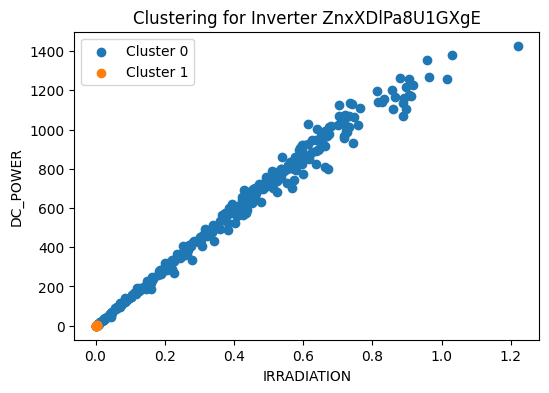

Silhouette Score for Inverter ZnxXDlPa8U1GXgE: 0.9192857946354865


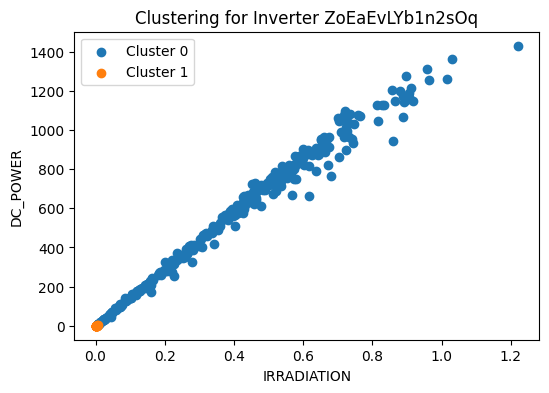

Silhouette Score for Inverter ZoEaEvLYb1n2sOq: 0.9146699455462619


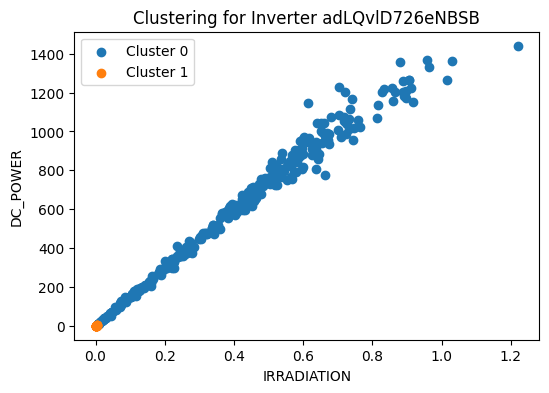

Silhouette Score for Inverter adLQvlD726eNBSB: 0.9158441171794657


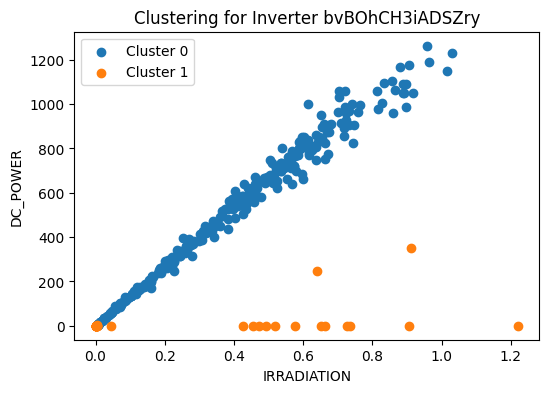

Silhouette Score for Inverter bvBOhCH3iADSZry: 0.9114440815167815


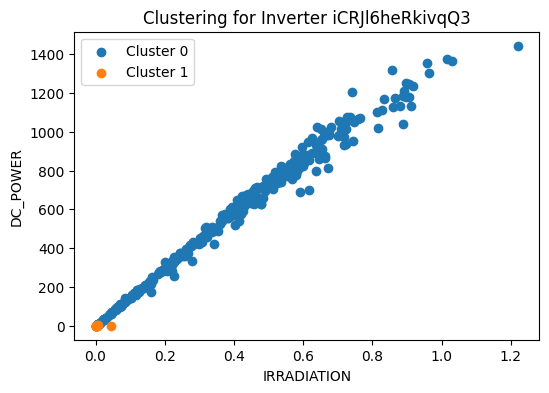

Silhouette Score for Inverter iCRJl6heRkivqQ3: 0.912517088909131


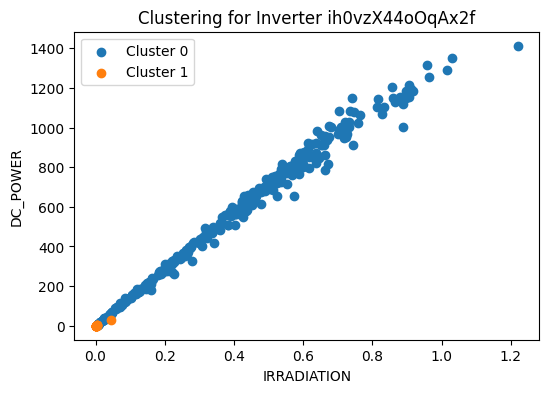

Silhouette Score for Inverter ih0vzX44oOqAx2f: 0.9196390089948764


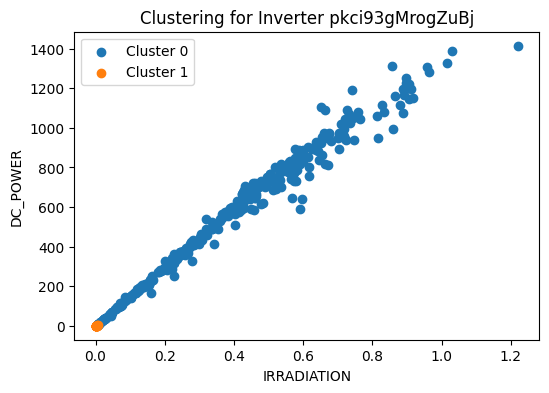

Silhouette Score for Inverter pkci93gMrogZuBj: 0.9026031208394232


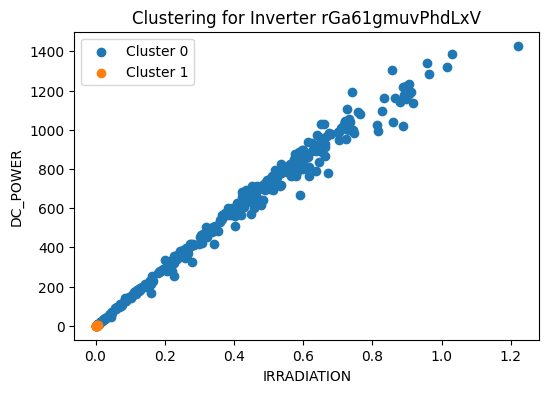

Silhouette Score for Inverter rGa61gmuvPhdLxV: 0.908515801786121


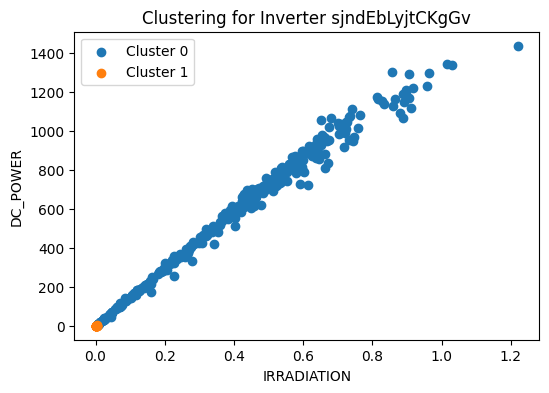

Silhouette Score for Inverter sjndEbLyjtCKgGv: 0.9176026010494921


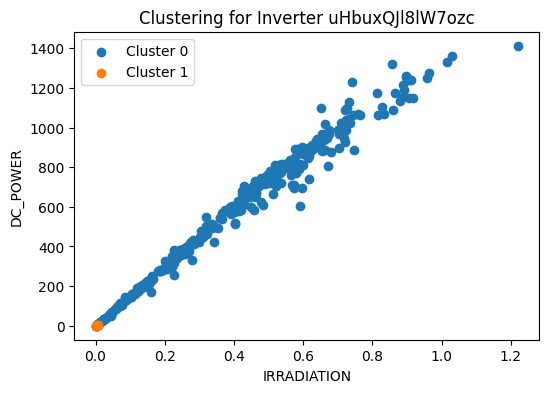

Silhouette Score for Inverter uHbuxQJl8lW7ozc: 0.9038854302977617


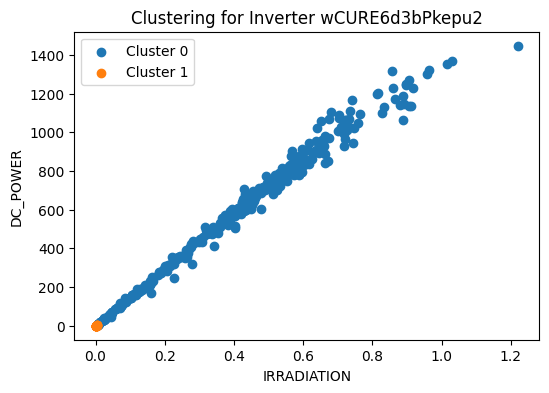

Silhouette Score for Inverter wCURE6d3bPkepu2: 0.9099820242325403


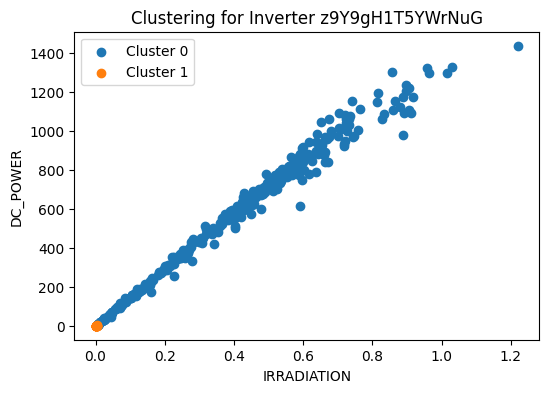

Silhouette Score for Inverter z9Y9gH1T5YWrNuG: 0.9115536706002396


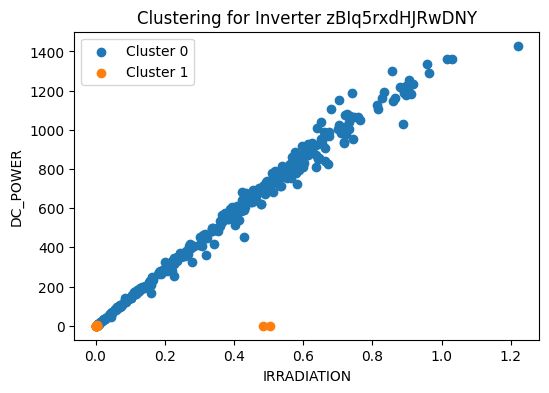

Silhouette Score for Inverter zBIq5rxdHJRwDNY: 0.915055521669831


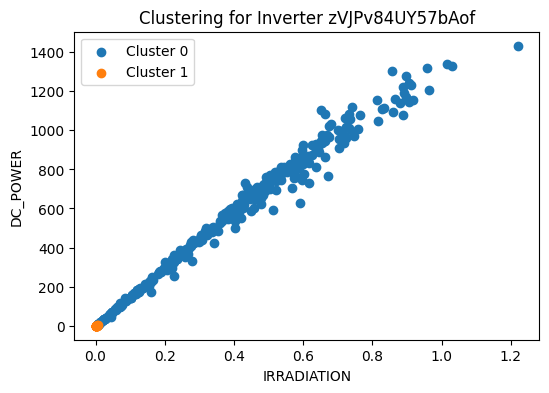

Silhouette Score for Inverter zVJPv84UY57bAof: 0.907566233463083


In [40]:
# prompt: use the fitted algorithms to predict the clusters for each inverter separately and visualize this result. Do it for both test_1 and test_2. Also, calculate Silhouette score for each inverter. The test_1 and test_2 have feature "SOURCE_KEY" and I want each source key to be clusterer separately, visualized separately and Silhouette score to be calculated separately!

import matplotlib.pyplot as plt

def predict_and_visualize(df, model, source_key_col, feature_col, cluster_col):
    """Predicts clusters for each inverter and visualizes the results."""

    for source_key in df[source_key_col].unique():
        inverter_data = df[df[source_key_col] == source_key].copy()
        inverter_data[cluster_col] = model.predict(inverter_data[feature_col].values.reshape(-1,1))

        plt.figure(figsize=(6, 4))
        for cluster in inverter_data[cluster_col].unique():
            cluster_data = inverter_data[inverter_data[cluster_col] == cluster]
            plt.scatter(cluster_data['IRRADIATION'], cluster_data['DC_POWER'], label=f'Cluster {cluster}')

        plt.title(f'Clustering for Inverter {source_key}')
        plt.xlabel('IRRADIATION')
        plt.ylabel('DC_POWER')
        plt.legend()
        plt.show()

        silhouette_avg = silhouette_score(inverter_data[[feature_col]], inverter_data[cluster_col], metric='euclidean')
        print(f"Silhouette Score for Inverter {source_key}: {silhouette_avg}")

# Predict and visualize for test_1 using kmeans_1
predict_and_visualize(test_1, kmeans_1, 'SOURCE_KEY', 'DC/IRR', 'KM_clusters_new')

# Predict and visualize for test_2 using kmeans_2
#predict_and_visualize(test_2, kmeans_2, 'SOURCE_KEY', 'DC/IRR', 'KM_clusters_new')

## <font color = 'lightgreen'>  Clustering **inverters** to faulty and good based on DC/IRR

In [ ]:
# Find all unique SOURCE_KEY values (inverters)
inverters_1 = uuritav_1['SOURCE_KEY_x'].unique()
inverters_2 = uuritav_2['SOURCE_KEY_x'].unique()
inverters = np.concatenate((inverters_1, inverters_2))

inverter_datas = dict()

for inverter in inverters_1:
    inverter_data = uuritav_1[uuritav_1['SOURCE_KEY_x'] == inverter]['DC/IRR'].values
    inverter_data = (inverter_data-np.min(inverter_data)) / (np.max(inverter_data) - np.min(inverter_data))
    inverter_datas[inverter] = inverter_data


for inverter in inverters_2:
    inverter_data = uuritav_2[uuritav_2['SOURCE_KEY_x'] == inverter]['DC/IRR'].values
    inverter_datas[inverter] = inverter_data

inverters_df = pd.DataFrame.from_dict(inverter_datas, orient='index').transpose()
inverters_df.dropna(inplace=True)
inverters_df = inverters_df.transpose()
inverters_df.shape

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)

#agg = AgglomerativeClustering(n_clusters=2,
#                              metric='correlation',
#                             linkage='complete')

kmeans = KMeans(n_clusters=2, random_state=42)

#inverters_df['KM_clusters'] = agg.fit_predict(inverters_df)
inverters_df['KM_clusters'] = kmeans.fit_predict(inverters_df)

In [ ]:
fail = pd.read_csv(dir+'manual_labelling_scores.csv')
fail.drop(columns = ['Dummy'], inplace = True)
fail['Gold'] = fail.mode(axis=1)[0]
fail.head(100)

# Assuming your original DataFrame is called 'df'
final_df = fail[['Inverter', 'Gold']].set_index('Inverter')
final_df.head(100)

final_df['KM_labels'] = final_df.index.map(inverters_df['KM_clusters'])

accuracy = (final_df['Gold'] == final_df['KM_labels']).mean()
print(f"Accuracy: {accuracy * 100:.2f}%")
print(final_df.head(44))

## Clustering with K-means

In [ ]:
clean_df = combined_2.copy().dropna()
# Reshape the feature for clustering
X = clean_df[['DC_POWER', 'IRRADIATION', 'AC_POWER', 'DC/AC']]
# Specify the number of clusters
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
clean_df['cluster'] = kmeans.fit_predict(X)

# Plotting
plt.figure(figsize=(8, 4))
plt.scatter(y = clean_df[clean_df['cluster'] == 0]['DC_POWER'], x = clean_df[clean_df['cluster'] == 0]['IRRADIATION'], label='Cluster 0', color = "forestgreen", s = 10)
plt.scatter(y = clean_df[clean_df['cluster'] == 1]['DC_POWER'], x = clean_df[clean_df['cluster'] == 1]['IRRADIATION'], label='Cluster 1', color = "firebrick", s = 10)
plt.title(f'K-Means Clustering (k={k})')
plt.ylabel('DC_POWER')
plt.xlabel('IRRADIATION')  # Corrected y-axis label
plt.legend()  # Add a legend to distinguish clusters
plt.show()

In [ ]:
top_10_values = clean_df.nlargest(10, columns = ['DC/IRR'])
top_10_values

In [ ]:

# Assuming your DataFrame is named 'df'
X = clean_df[['DC/IRR']].copy()  # Select 'DC/IRR' column for clustering

# Replace inf values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
X.dropna(inplace=True)

# Initialize KMeans with desired number of clusters
k = 2  # Choose an appropriate number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit the model to the scaled data
kmeans.fit(X)

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

# Add cluster labels to your original DataFrame
clean_df['cluster'] = pd.Series(cluster_labels, index=X.index)

# Plotting
plt.scatter(clean_df['DC_POWER'], clean_df['cluster'], cmap='viridis')
plt.title(f'K-Means Clustering (k={k})')
plt.xlabel('DC_POWER')
plt.ylabel('Cluster')
plt.show()

In [ ]:
# Plotting
plt.figure(figsize=(8, 4))
plt.scatter(y = clean_df[clean_df['cluster'] == 0]['DC_POWER'], x = clean_df[clean_df['cluster'] == 0]['IRRADIATION'], label='Normal', color = "forestgreen", s = 10)
plt.scatter(y = clean_df[clean_df['cluster'] == 1]['DC_POWER'], x = clean_df[clean_df['cluster'] == 1]['IRRADIATION'], label='Faulty', color = "firebrick", s = 10)
#plt.scatter(x = clean_df[clean_df['cluster'] == 2]['DC_POWER'], y = clean_df[clean_df['cluster'] == 2]['IRRADIATION'], label='Cluster 2')
plt.title(f'K-Means Clustering (k={k})')
plt.ylabel('DC_POWER')
plt.xlabel('IRRADIATION')  # Corrected y-axis label
plt.legend()  # Add a legend to distinguish clusters
plt.show()

In [ ]:
# prompt: use dbscan instead of k-means for clustering and visualize the clusters. You should use the 'DC/IRR' column for clustering. Use only color to separate the clusters and use most simpel dots on graphs. make the noise points black and others (red, green, blue, orange) use as many colors as needed. Make sure to avoid error:ValueError: Length of values (38722) does not match length of index (38736)
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'clean_df' and 'X' is already prepared as in your provided code
X = clean_df[['DC/IRR']].copy()
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

# Initialize DBSCAN with eps and min_samples
dbscan = DBSCAN(eps=15, min_samples=100) # You might need to tune these parameters

# Fit the model to the data
dbscan.fit(X)

# Get cluster labels
cluster_labels = dbscan.labels_

# Add cluster labels to the DataFrame
clean_df['cluster'] = pd.Series(cluster_labels, index=X.index)

# Define a color map for the clusters, including black for noise points
colors = ['black', 'forestgreen', 'red', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'firebrick'] # Add more colors as needed

# Plotting
plt.figure(figsize=(8, 4))
for i in range(-1, max(cluster_labels) + 1): # Iterate over all clusters including noise (-1)
    cluster_data = clean_df[clean_df['cluster'] == i]
    if len(cluster_data) > 0: # Check if there is data in that cluster
        plt.scatter(y = cluster_data['DC_POWER'], x = cluster_data['IRRADIATION'],
                    c=colors[i % len(colors)], label=f'Cluster {i}', s=10) # use a simple dot

plt.title('DBSCAN Clustering')
plt.ylabel('DC_POWER')
plt.xlabel('IRRADIATION')
plt.legend()
plt.show()

In [ ]:
# prompt: now, use agglomerative clustering for the same task. Visualise as before

from sklearn.cluster import AgglomerativeClustering

# Assuming your DataFrame is named 'clean_df' and 'X' is already prepared as in your provided code
X = clean_df[['DC/IRR']].copy()
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

# Initialize Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=3) # You can change the number of clusters

# Fit the model
agg_clustering.fit(X)

# Get cluster labels
cluster_labels = agg_clustering.labels_

# Add cluster labels to the DataFrame
clean_df['cluster'] = pd.Series(cluster_labels, index=X.index)
colors = ['forestgreen', 'firebrick', 'black']
labels = ['Normal', 'Dirty', 'Faulty']

# Plotting
plt.figure(figsize=(8, 4))
for i in range(max(cluster_labels) + 1):  # Iterate over all clusters
    cluster_data = clean_df[clean_df['cluster'] == i]
    plt.scatter(y =cluster_data['DC_POWER'], x =  cluster_data['IRRADIATION'], label=labels[i], s=10, color = colors[i])

plt.title('Agglomerative Clustering')
plt.xlabel('DC_POWER')
plt.ylabel('IRRADIATION')
plt.legend()
plt.show()

In [ ]:
# prompt: plot me: y= average DC/AC by inverter,  x = inverter

import matplotlib.pyplot as plt

# Assuming 'combined_1' DataFrame is already defined and contains 'SOURCE_KEY_x' and 'DC/AC' columns.
# Calculate the average DC/AC for each inverter
average_dc_ac_by_inverter = combined_1.groupby('SOURCE_KEY_x')['DC/AC'].mean()

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(combined_1['DC_POWER'], combined_1['AC_POWER'], marker='o')
plt.xlabel('Inverter (SOURCE_KEY_x)')
plt.ylabel('Average DC/AC')
plt.title('Average DC/AC Ratio by Inverter')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'clean_df' and 'X' is already prepared as in your provided code
X = clean_df[['DC/AC']].copy()
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

# Initialize DBSCAN with eps and min_samples
kmeans = KMeans(n_clusters=2, random_state=42)

# Fit the model to the data
kmeans.fit(X)

# Get cluster labels
cluster_labels = dbscan.labels_

# Add cluster labels to the DataFrame
clean_df['cluster'] = pd.Series(cluster_labels, index=X.index)

# Define a color map for the clusters, including black for noise points
colors = ['black', 'forestgreen', 'red', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'firebrick'] # Add more colors as needed

# Plotting
plt.figure(figsize=(8, 4))
for i in range(-1, max(cluster_labels) + 1): # Iterate over all clusters including noise (-1)
    cluster_data = clean_df[clean_df['cluster'] == i]
    if len(cluster_data) > 0: # Check if there is data in that cluster
        plt.scatter(y = cluster_data['DC_POWER'], x = cluster_data['AC_POWER'],
                    c=colors[i % len(colors)], label=f'Cluster {i}', s=10) # use a simple dot

plt.title('DBSCAN Clustering')
plt.ylabel('DC_POWER')
plt.xlabel('AC_POWER')
plt.legend()
plt.show()

In [ ]:
predicted_labels = kmeans.predict(combined_2[['DC/IRR']])
combined_2['cluster'] = pd.Series(predicted_labels, index=combined_2.index)

In [ ]:
# prompt: I want to use the agg_clustering defined above to label all the dataset combined_2

# Assuming 'agg_clustering' is already defined and fitted as in your provided code
# and 'combined_2' DataFrame is also available.

# Prepare the data for prediction
X_combined_2 = combined_2[['DC/IRR']].copy()
X_combined_2.replace([np.inf, -np.inf], np.nan, inplace=True)
X_combined_2.dropna(inplace=True)

# Predict cluster labels for combined_2
combined_2['cluster'] = pd.Series(agg_clustering.fit_predict(X_combined_2), index=X_combined_2.index)

# Now 'combined_2' DataFrame has a new 'cluster' column with the predicted labels

In [ ]:
plt.hist(X, bins = 100)
plt.show()

In [ ]:
# Example: Scatter plot of two features colored by cluster
plt.plot(combined_2['DC/IRR'])
plt.xlabel('DC_POWER')
#plt.ylabel('IRRADIATION')
plt.title('K-means Clustering')
plt.show()

In [ ]:
plant_1_GD.where(plant_1_GD['SOURCE_KEY'] == 'bvBOhCH3iADSZry').dropna()[['DATE_TIME', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD']]

In [ ]:
vahetabel.head()

In [ ]:
vahetabel = pd.DataFrame()
data = plant_1_GD.where(plant_1_GD['SOURCE_KEY'] == 'bvBOhCH3iADSZry').dropna()[['DATE_TIME', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']]
vahetabel["DAILY_YIELD"] = data["DAILY_YIELD"]
vahetabel["AC_POWER"] = data["AC_POWER"]
vahetabel["DC_POWER"] = data["DC_POWER"]
vahetabel["TOTAL_YIELD"] = data["TOTAL_YIELD"]
vahetabel["päevatootlus_dif"] = vahetabel["DAILY_YIELD"]-vahetabel["DAILY_YIELD"].shift(1)
vahetabel["kogutootlus_dif"] = vahetabel["TOTAL_YIELD"]-vahetabel["TOTAL_YIELD"].shift(1)
vahetabel["kogutootlus"] = vahetabel["DC_POWER"].cumsum()
vahetabel.tail(100)

#plt.scatter(vahetabel["kogutootlus_dif"], vahetabel["DC_POWER"].shift(1))
plt.figure(figsize = (8,4))
plt.plot(vahetabel["kogutootlus"]/4/10, color = "darkblue", lw = 4)
plt.plot(vahetabel["TOTAL_YIELD"]-(data["TOTAL_YIELD"]).min(), color = "red", lw = 2)
plt.legend(["Calculated total yield", "Total yield from data"])
plt.title('Cumulative DC power for one inverter trhoughout the observation period')
plt.xlabel('Observation')
plt.ylabel('Generated DC power (kWh)')
#plt.plot(vahetabel["kogutootlus_dif"][:90])
#plt.plot(vahetabel["päevatootlus_dif"][:90])
#plt.plot(vahetabel["AC_POWER"][:90]/5)
plt.show()


In [ ]:
vahetabel_2 = pd.DataFrame()
data = plant_2_GD.where(plant_2_GD['SOURCE_KEY'] == '81aHJ1q11NBPMrL').dropna()[['DATE_TIME', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD']]
vahetabel_2["DAILY_YIELD"] = data["DAILY_YIELD"]
vahetabel_2["AC_POWER"] = data["AC_POWER"]
vahetabel_2["DC_POWER"] = data["DC_POWER"]
vahetabel_2["päevatootlus"] = -vahetabel_2["DAILY_YIELD"]+vahetabel_2["DAILY_YIELD"].shift(1)
vahetabel_2.head(100)

In [ ]:
plt.scatter(vahetabel_2["päevatootlus"][96:96*3+1], vahetabel_2["AC_POWER"][96:96*3+1])
#plt.plot(vahetabel["päevatootlus"][:100])
#plt.plot(vahetabel["AC_POWER"][:100])
plt.show()

Proovime plottida ühe inverteri tootluse ajas

In [ ]:
inverterid_1 = plant_1_GD['SOURCE_KEY'].unique()
inverterid_2 = plant_2_GD['SOURCE_KEY'].unique()


inverterid = pd.DataFrame()

for inverter in inverterid_1:
    data = plant_1_GD.where(plant_1_GD['SOURCE_KEY'] == inverter).dropna()
    inverterid[inverter] = data['DC_POWER'].reset_index(drop=True)

for inverter in inverterid_2:
    data = plant_2_GD.where(plant_2_GD['SOURCE_KEY'] == inverter).dropna()
    inverterid[inverter] = data['DC_POWER'].reset_index(drop=True)



# Calculate number of rows and columns for subplots
num_cols = 4  # 4 subplots in one row
num_rows = (len(inverterid.columns) + num_cols - 1) // num_cols  # Calculate rows needed

# Create figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 4 * num_rows))  # Adjust figsize as needed

# Flatten axes for easier iteration
axes = axes.flatten()

# Iterate and plot
for i, column in enumerate(inverterid.columns):
    axes[i].plot(inverterid[column])
    axes[i].set_title(column)  # Set title
    axes[i].set_xlabel("Index")
    axes[i].set_ylabel("DC Power")

# Hide any unused subplots
for j in range(i + 1, num_rows * num_cols):
    axes[j].axis('off')

plt.tight_layout()  # Adjust spacing
plt.show()

In [ ]:
plant_1_GD['DC_POWER'].max()

In [ ]:
plot_DC_IRR(combined_2, 'xoJJ8DcxJEcupym', pdf = True)

In [ ]:
plot_DC_vs_IRR(combined_2, 'xoJJ8DcxJEcupym')

## Defined functions

In [ ]:
def plot_DC_vs_IRR(combined_data, source_key):
    """
    Plots DC_POWER and IRRADIATION for a specific inverter over time, grouped by day.

    Args:
        combined_data: DataFrame containing combined plant generation and weather data.
        source_key: The SOURCE_KEY of the inverter to plot.
    """

    filtered_data = combined_data[combined_data['SOURCE_KEY_x'] == source_key]

    # Group data by day
    days = filtered_data.groupby(filtered_data['DATE_TIME'].dt.date)

    # Calculate number of rows and columns for subplots
    num_cols = 4
    num_rows = (len(days) + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 4 * num_rows), sharex=False)
    axes = axes.flatten()

    for i, (day, day_data) in enumerate(days):
        axes[i].plot(day_data['DATE_TIME'], day_data['DC/IRR'], label='DC/IRR')
        axes[i].set_title(f'Day: {day}')
        axes[i].set_xlabel("Time")
        axes[i].set_ylabel("DC/IRR")



        # Rotate x-axis labels for better readability (optional)
        plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')

    for j in range(i + 1, num_rows * num_cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# prompt: make it a function that takes in combined data and the source_key value (as string)
import matplotlib.dates as mdates

def plot_DC_IRR(combined_data, source_key, pdf=False):
    """
    Plots DC_POWER and IRRADIATION for a specific inverter over time, grouped by day.

    Args:
        combined_data: DataFrame containing combined plant generation and weather data.
        source_key: The SOURCE_KEY of the inverter to plot.
        pdf: Boolean indicating whether to save the plot to a PDF.
    """

    filtered_data = combined_data[combined_data['SOURCE_KEY_x'] == source_key]

    # Group data by day
    days = filtered_data.groupby(filtered_data['DATE_TIME'].dt.date)

    # Calculate number of rows and columns for subplots
    num_cols = 4
    num_rows = (len(days) + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 4 * num_rows), sharex=False)
    axes = axes.flatten()

    for i, (day, day_data) in enumerate(days):
        # Plot DC_POWER on the primary y-axis
        axes[i].plot(day_data['DATE_TIME'], day_data['DC_POWER'], label='DC_POWER')
        axes[i].set_title(f'Day: {day}')
        axes[i].set_xlabel("Time")
        axes[i].set_ylabel("DC_POWER", color = "blue")
        axes[i].legend(loc="upper left", prop={'size': 8})  # DC_POWER legend in upper left

        # Plot IRRADIATION on the secondary y-axis
        ax2 = axes[i].twinx()
        ax2.plot(day_data['DATE_TIME'], day_data['IRRADIATION'], color='red', alpha=0.8, label='IRR')
        ax2.set_ylabel('IRRADIATION', color='red')
        ax2.tick_params('y', labelcolor='black')
        ax2.legend(loc="upper right", prop={'size': 8})  # IRRADIATION legend in upper right

        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())  # Optional: auto adjust tick frequency
        # Rotate x-axis labels for better readability
        plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')

    # Turn off any unused subplots
    for j in range(i + 1, num_rows * num_cols):
        axes[j].axis('off')

    plt.tight_layout()

    # Save to PDF if specified
    if pdf:
        plt.savefig(f'{source_key}.pdf')

    plt.show()
